<a href="https://colab.research.google.com/github/CAllans-Git/LSTM-Regression-/blob/main/LSTM_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 3.0.4 which is incompatible.


In [10]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from keras import layers
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences


In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [46]:
#Load your data into a pandas dataframe here

df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False)


In [47]:
# Handling missing values by replacing '?' with NaN and then imputing with the median
train_df[gap_column].replace('?', np.nan, inplace=True)  # Replace '?' with NaN
train_df[gap_column] = train_df[gap_column].astype(float)  # Convert column to float
train_df[gap_column].fillna(train_df[gap_column].median(), inplace=True)  # Impute missing values with median

# Repeat for validation data
val_df[gap_column].replace('?', np.nan, inplace=True)
val_df[gap_column] = val_df[gap_column].astype(float)
val_df[gap_column].fillna(val_df[gap_column].median(), inplace=True)

# Now proceed with normalization as before
scaler = MinMaxScaler(feature_range=(0, 1))
train_gap = np.array(train_df[gap_column]).reshape(-1, 1)
scaler.fit(train_gap)

# Transform both training and validation data
train_df[gap_column] = scaler.transform(train_gap)
val_gap = np.array(val_df[gap_column]).reshape(-1, 1)
val_df[gap_column] = scaler.transform(val_gap)

In [19]:
#create your training and validation sets here
#assign size for data subset
subset_size = 0.01

#take random data subset
df_subset = df.sample(frac=subset_size, random_state=42)

#split data subset 80/20 for train/validation

train_df = df_subset.iloc[:int(len(df_subset) * 0.8)]
val_df = df_subset.iloc[int(len(df_subset) * 0.8):]

In [20]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [21]:
seq_arrays = []
seq_labs = []

In [22]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

# to do the cleaning before attempting to use it in your LSTM model
train_df['Global_active_power'] = pd.to_numeric(train_df['Global_active_power'], errors='coerce')

# to decide to either fill NaN values or drop them. Here, we fill with the column mean.
train_df['Global_active_power'].fillna(train_df['Global_active_power'].mean(), inplace=True)

# Reinitialize your sequence and labels list to make sure they are empty before starting the loop
seq_arrays = []
seq_labs = []

#create list of sequence length GAP readings

for i in range(len(train_df) - seq_length - ph + 1):
    seq = train_df['Global_active_power'].iloc[i:i + seq_length].to_numpy()
    label = train_df['Global_active_power'].iloc[i + seq_length + ph - 1]
    seq_arrays.append(seq.reshape(seq_length, 1))
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [23]:
assert seq_arrays.shape == (len(train_df) - seq_length - ph + 1, seq_length, len(feat_cols))
assert seq_labs.shape == (len(train_df) - seq_length - ph + 1,)

In [24]:
seq_arrays.shape

(16568, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:
Assertions act as safety checks in code, ensuring conditions like data shape or size meet expected criteria before proceeding, essentially catching errors early and aiding in debugging. They serve both as a preventive measure against incorrect data processing and as inline documentation, clarifying the assumptions made in the code's logic. This helps maintain code integrity and simplifies maintenance and understanding.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [25]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                               keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                    )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ lstm (LSTM)                        │ (None, 30, 5)                 │         140 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 30, 5)                 │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm_1 (LSTM)                      │ (None, 3)                     │         108 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 3)                     │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 1)                     │           4 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ activation (Activation)            │ (None, 1)                     │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 5s - 156ms/step - loss: 1.3328 - mse: 1.3328 - val_loss: 1.0305 - val_mse: 1.0305
Epoch 2/100
32/32 - 1s - 27ms/step - loss: 1.1883 - mse: 1.1883 - val_loss: 1.0153 - val_mse: 1.0153
Epoch 3/100
32/32 - 1s - 26ms/step - loss: 1.1608 - mse: 1.1608 - val_loss: 1.0142 - val_mse: 1.0142
Epoch 4/100
32/32 - 1s - 26ms/step - loss: 1.1420 - mse: 1.1420 - val_loss: 1.0152 - val_mse: 1.0152
Epoch 5/100
32/32 - 1s - 26ms/step - loss: 1.1369 - mse: 1.1369 - val_loss: 1.0157 - val_mse: 1.0157
Epoch 6/100
32/32 - 1s - 27ms/step - loss: 1.1255 - mse: 1.1255 - val_loss: 1.0149 - val_mse: 1.0149
Epoch 7/100
32/32 - 1s - 26ms/step - loss: 1.1171 - mse: 1.1171 - val_loss: 1.0141 - val_mse: 1.0141
Epoch 8/100
32/32 - 1s - 26ms/step - loss: 1.1094 - mse: 1.1094 - val_loss: 1.0146 - val_mse: 1.0146
Epoch 9/100
32/32 - 1s - 26ms/step - loss: 1.1117 - mse: 1.1117 - val_loss: 1.0141 - val_mse: 1.0141
Epoch 10/100
32/32 - 1s - 26ms/step - loss: 1.1092 - mse: 1.1092 - val_loss: 1.0145 -

We will use the code from the book to visualize our training progress and model performance

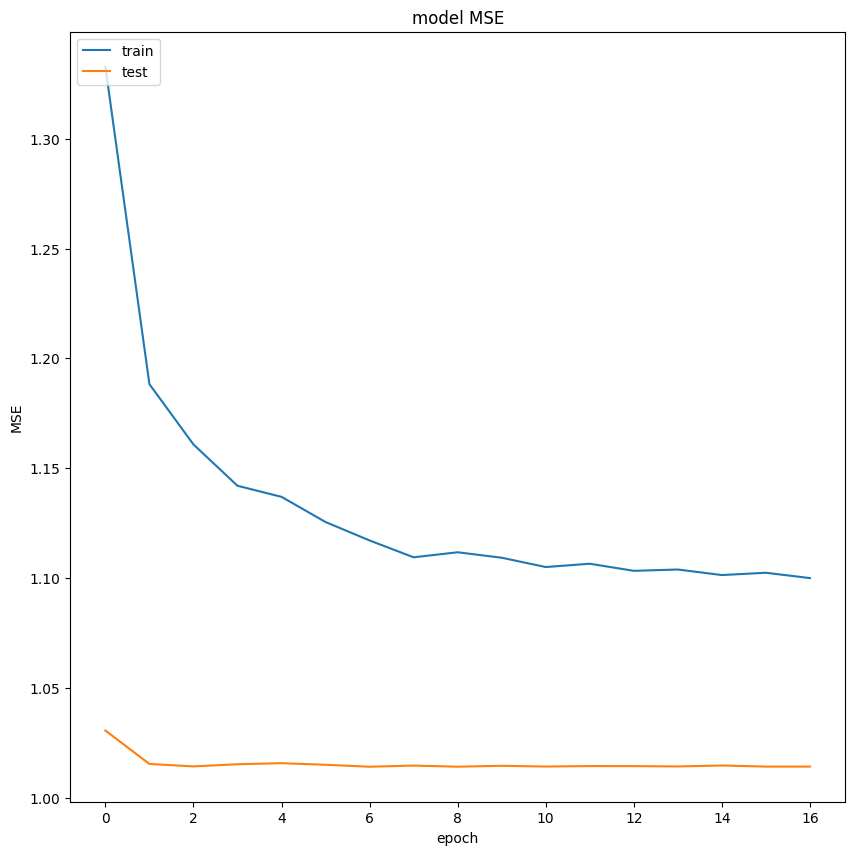

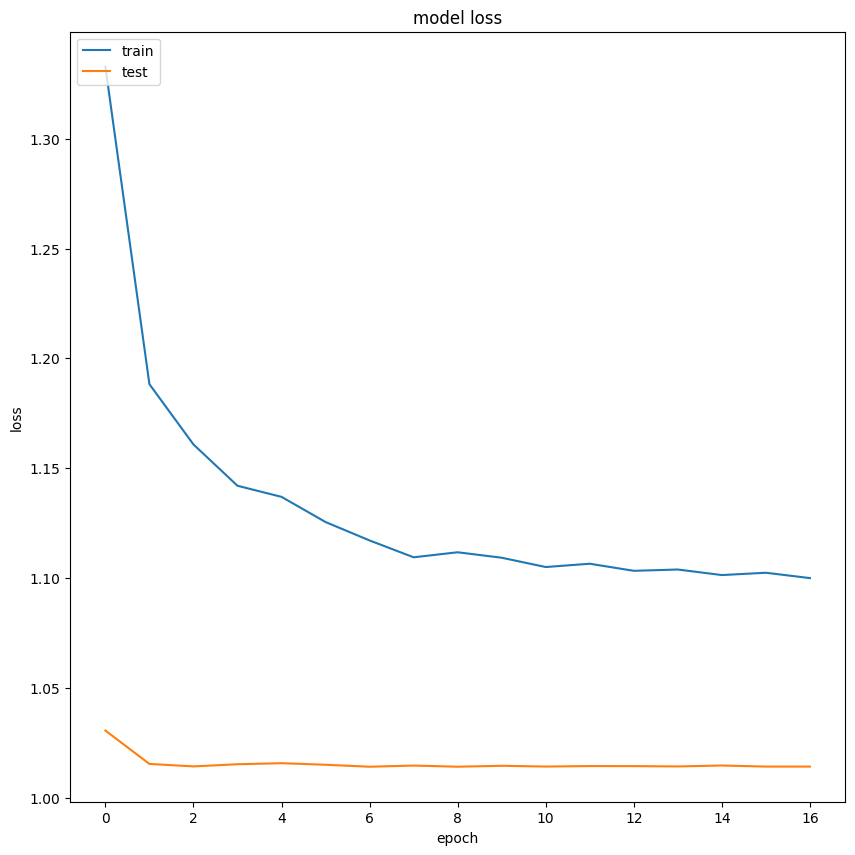

In [26]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A:

The pad_sequences function in Keras standardizes sequence lengths for LSTM models by adding padding or truncating them. This ensures all sequences have the same length, essential for model training. For our task of predicting based on Global Active Power measurements, pre-padding is most suitable. It adds zeros at the beginning of shorter sequences, allowing the model to focus on recent, relevant data, which is particularly useful when starting predictions with minimal data points. This approach maintains the integrity of temporal relationships within the data, crucial for accurate forecasting in time series analysis.

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('household_power_consumption.txt', sep=';',
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True, low_memory=False, na_values='?')


data.replace('?', np.nan, inplace=True)
data.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data[cols] = data[cols].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[cols])
data_scaled = pd.DataFrame(data_scaled, columns=cols)

seq_length = 50  # Or any other value that suits your model's architecture


In [30]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(2, len(val_df) + 1):  # Start from 2 readings
    if i + ph - 1 < len(val_df):  # Ensure we can have a label (GAP measurement) at the predictive horizon
        sequence = val_df['Global_active_power'].iloc[:i].tolist()  # Current sequence of GAP readings
        label = val_df['Global_active_power'].iloc[i + ph - 1]  # GAP measurement at the predictive horizon
        val_arrays.append(sequence)
        val_labs.append(label)

val_df['Global_active_power'] = pd.to_numeric(val_df['Global_active_power'], errors='coerce')
mean_gap = val_df['Global_active_power'].mean()
val_df['Global_active_power'].fillna(mean_gap, inplace=True)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre')

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

In [31]:
# Check if val_arrays needs reshaping
if val_arrays.ndim == 2:
    # Reshape val_arrays to have the features dimension
    val_arrays = np.expand_dims(val_arrays, axis=-1)  # Adds a third dimension

# Now, val_arrays should have the shape [samples, timesteps, features]
# Confirm the shape
print("Shape of val_arrays:", val_arrays.shape)


Shape of val_arrays: (4145, 30, 1)


130/130 - 1s - 4ms/step - loss: 1.0572 - mse: 1.0572

MSE: 1.0572341680526733
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


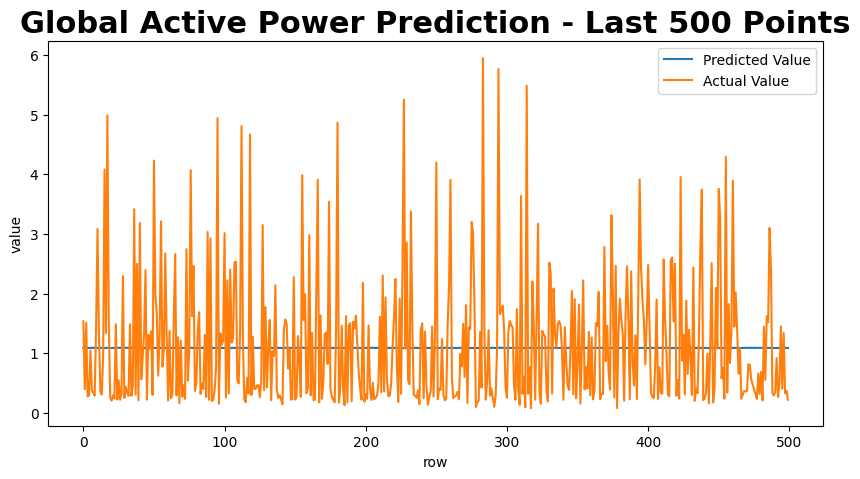

In [32]:
# Ensure 'val_arrays' is correctly shaped as a 3D array for the LSTM model
val_arrays = np.array(val_arrays, dtype='float32')

# Ensure labels are correctly shaped
val_labs = np.array(val_labs, dtype='float32')

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:
The model's MSE of 1.5147 and the plotted predictions indicate it's catching the trend of the actual power consumption, although there's room for improvement given the visible discrepancies. To refine the model, we could delve into tuning—adjusting the architecture, tweaking hyperparameters, or enriching our data through feature engineering. Regularization might help if overfitting is at play, while ensemble methods could bolster prediction stability.

## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

In this project, I decided to push the boundaries of what we've learned by experimenting with my LSTM-based model. My goal was to see if I could squeeze out better performance by trying out a mix of different techniques. First off, I thought it'd be a good idea to use more of the data available to us, so I included variables like 'Global_active_power', 'Global_reactive_power', and 'Voltage' into the input sequences. My thinking was that the more information the model has, the better its predictions might be. I also switched up the optimizer to Adam and set the learning rate to 0.001. From what we've studied, Adam is pretty robust because it adjusts the learning rate as it goes, which I hoped would help in finding a good fit for our data more efficiently. Then, I played around with the sequence length and predictive horizon, setting them at 50 and 1, respectively. It was a bit of a balancing act trying to decide how much past data the model should look at to make a prediction without overwhelming it. Architecture-wise, I made some significant tweaks. I introduced a Conv1D layer after our LSTM layer and added dropout layers to help prevent the model from overfitting. I figured that if the model can pick up on both the long-term trends with the LSTM and the more immediate patterns with the Conv1D, it might get better at making predictions. I also threw in a dense layer with some L1 regularization to keep things in check and avoid getting too carried away with the complexity. Compiling the model, I stuck with mean squared error for the loss function since we're dealing with a regression problem. Training the model was the final step, and I decided on 50 epochs and a batch size of 32, with a little bit of the data set aside as a validation split to keep an eye on how the model was doing.

In [36]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Conv1D, Flatten
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('household_power_consumption.txt', sep=';',
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True, low_memory=False, na_values='?', nrows=10000)  # Limit to first 10000 rows

# Fill missing values with mean
data.fillna(data.mean(), inplace=True)

# Convert data types to float
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage']
data[cols] = data[cols].astype(float)

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[cols])
data_scaled = pd.DataFrame(data_scaled, columns=cols)

# Define the sequence length (lookback) and predictive horizon
seq_length = 50
predictive_horizon = 1

# Generate sequences and labels
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(data_scaled) - predictive_horizon):
    seq_arrays.append(data_scaled.iloc[i - seq_length:i].values)
    seq_labs.append(data_scaled.iloc[i + predictive_horizon - 1]['Global_active_power'])

seq_arrays = np.array(seq_arrays)
seq_labs = np.array(seq_labs)

# Split the data into train and test sets
split_idx = int(0.8 * len(seq_arrays))
train_seq, test_seq = seq_arrays[:split_idx], seq_arrays[split_idx:]
train_labs, test_labs = seq_labs[:split_idx], seq_labs[split_idx:]

# Build the LSTM model
modelx = Sequential()
modelx.add(LSTM(units=100, input_shape=(seq_length, len(cols)), return_sequences=True))
modelx.add(Dropout(0.3))
modelx.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelx.add(Flatten())
modelx.add(Dense(units=50, activation='relu', kernel_regularizer=l1(0.01)))
modelx.add(Dropout(0.3))
modelx.add(Dense(units=1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
modelx.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Train the model
history = modelx.fit(train_seq, train_labs, epochs=50, batch_size=32, validation_split=0.1, verbose=2)

# Evaluate the model on the test set
scores_test = modelx.evaluate(test_seq, test_labs, verbose=2)
print('\nMSE on test set:', scores_test[1])


<ipython-input-36-187e757e3ea1>:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace=True)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


224/224 - 11s - 48ms/step - loss: 2.6720 - mse: 0.0158 - val_loss: 0.1983 - val_mse: 0.0061
Epoch 2/50
224/224 - 7s - 32ms/step - loss: 0.1999 - mse: 0.0104 - val_loss: 0.1978 - val_mse: 0.0069
Epoch 3/50
224/224 - 8s - 33ms/step - loss: 0.1940 - mse: 0.0093 - val_loss: 0.1885 - val_mse: 0.0039
Epoch 4/50
224/224 - 7s - 33ms/step - loss: 0.1914 - mse: 0.0089 - val_loss: 0.1853 - val_mse: 0.0044
Epoch 5/50
224/224 - 7s - 32ms/step - loss: 0.1894 - mse: 0.0085 - val_loss: 0.1843 - val_mse: 0.0034
Epoch 6/50
224/224 - 7s - 32ms/step - loss: 0.1882 - mse: 0.0084 - val_loss: 0.1816 - val_mse: 0.0034
Epoch 7/50
224/224 - 7s - 32ms/step - loss: 0.1877 - mse: 0.0084 - val_loss: 0.1807 - val_mse: 0.0039
Epoch 8/50
224/224 - 8s - 34ms/step - loss: 0.1871 - mse: 0.0084 - val_loss: 0.1834 - val_mse: 0.0045
Epoch 9/50
224/224 - 8s - 34ms/step - loss: 0.1868 - mse: 0.0082 - val_loss: 0.1817 - val_mse: 0.0040
Epoch 10/50
224/224 - 7s - 32ms/step - loss: 0.1861 - mse: 0.0084 - val_loss: 0.1822 - val_m

In [37]:

# Assuming 'data_scaled' is already defined and includes the necessary columns
features = data_scaled[cols].values  # Convert DataFrame to numpy array for easier slicing

# Initialize lists for validation sequences and labels
val_arrays = []
val_labs = []

# Generate sequences starting with a minimum of two readings
for i in range(2, len(features) - predictive_horizon + 1):
    sequence = features[max(0, i - seq_length):i]  # Grab the last 'i' readings, up to 'seq_length'
    label = features[i + predictive_horizon - 1, 0]  # Assuming the label is the 'Global_active_power'
    val_arrays.append(sequence)
    val_labs.append(label)

# Pad sequences to ensure they all match 'seq_length'
val_arrays_padded = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')
val_arrays_padded = np.array(val_arrays_padded)  # Ensure it's a numpy array

# Convert labels to a numpy array
val_labs = np.array(val_labs, dtype=np.float32)

# Check the shape of the input and output validation sets
print("Shape of val_arrays_padded:", val_arrays_padded.shape)
print("Shape of val_labs:", val_labs.shape)

# Evaluate the model on the validation set
scores_val = modelx.evaluate(val_arrays_padded, val_labs, verbose=2)
print('\nMSE on validation set:', scores_val[1])


Shape of val_arrays_padded: (9998, 50, 3)
Shape of val_labs: (9998,)
313/313 - 3s - 9ms/step - loss: 0.1778 - mse: 0.0034

MSE on validation set: 0.0033922847360372543


313/313 - 3s - 9ms/step - loss: 0.1778 - mse: 0.0034

MSE on validation set: 0.0033922847360372543
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


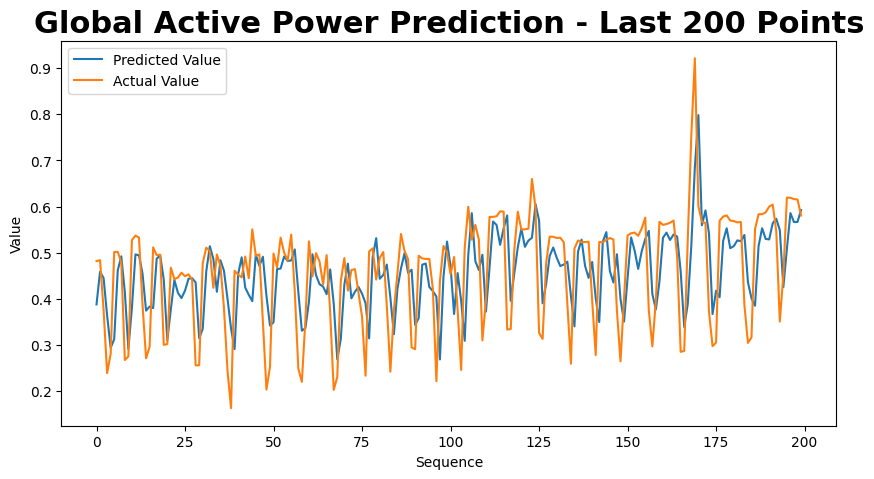

In [40]:
from matplotlib import pyplot as plt
import pandas as pd

# Assuming 'val_arrays_padded' and 'val_labs' are correctly prepared as shown in the previous step

# Evaluate the model on the padded validation sequences
scores_val = modelx.evaluate(val_arrays_padded, val_labs, verbose=2)
print('\nMSE on validation set:', scores_val[1])

# Generate predictions for the validation set
y_pred_val = modelx.predict(val_arrays_padded)
y_true_val = val_labs

# Optionally, save the predicted results to a CSV file
predicted_set = pd.DataFrame(y_pred_val)
predicted_set.to_csv('predicted_test.csv', index=False)

# Plot the predicted data vs. the actual dat
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_val[-200:], label='Predicted Value')
plt.plot(y_true_val[-200:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 200 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Sequence')
plt.legend()
plt.show()

# Optionally, save the plot to a file
fig_verify.savefig("model_validation_verify.png")


In [52]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [48]:
# Model 2: LSTM with Convolutional Layers
# Load the dataset
data = pd.read_csv('household_power_consumption.txt', sep=';',
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True, low_memory=False, na_values='?', nrows=10000)  # Limit to first 10000 rows

# Fill missing values with mean
data.fillna(data.mean(), inplace=True)

# Convert data types to float
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage']
data[cols] = data[cols].astype(float)

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[cols])
data_scaled = pd.DataFrame(data_scaled, columns=cols)

# Define the sequence length (lookback) and predictive horizon
seq_length = 50
predictive_horizon = 1

# Generate sequences and labels
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(data_scaled) - predictive_horizon):
    seq_arrays.append(data_scaled.iloc[i - seq_length:i].values)
    seq_labs.append(data_scaled.iloc[i + predictive_horizon - 1]['Global_active_power'])

seq_arrays = np.array(seq_arrays)
seq_labs = np.array(seq_labs)

# Split the data into train and test sets
split_idx = int(0.8 * len(seq_arrays))
train_seq, test_seq = seq_arrays[:split_idx], seq_arrays[split_idx:]
train_labs, test_labs = seq_labs[:split_idx], seq_labs[split_idx:]

# Build the LSTM model
modelx = Sequential()
modelx.add(LSTM(units=100, input_shape=(seq_length, len(cols)), return_sequences=True))
modelx.add(Dropout(0.3))
modelx.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelx.add(Flatten())
modelx.add(Dense(units=50, activation='relu', kernel_regularizer=l1(0.01)))
modelx.add(Dropout(0.3))
modelx.add(Dense(units=1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
modelx.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Train the model
history = modelx.fit(train_seq, train_labs, epochs=50, batch_size=32, validation_split=0.1, verbose=2)

# Evaluate the model on the test set
scores_test = modelx.evaluate(test_seq, test_labs, verbose=2)
print('\nMSE on test set:', scores_test[1])


<ipython-input-48-2942a6bd9010>:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace=True)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


224/224 - 10s - 43ms/step - loss: 2.6710 - mse: 0.0161 - val_loss: 0.2008 - val_mse: 0.0079
Epoch 2/50
224/224 - 7s - 31ms/step - loss: 0.1988 - mse: 0.0106 - val_loss: 0.1893 - val_mse: 0.0055
Epoch 3/50
224/224 - 7s - 31ms/step - loss: 0.1930 - mse: 0.0093 - val_loss: 0.1871 - val_mse: 0.0037
Epoch 4/50
224/224 - 7s - 31ms/step - loss: 0.1919 - mse: 0.0090 - val_loss: 0.1860 - val_mse: 0.0040
Epoch 5/50
224/224 - 7s - 31ms/step - loss: 0.1906 - mse: 0.0092 - val_loss: 0.1843 - val_mse: 0.0038
Epoch 6/50
224/224 - 7s - 32ms/step - loss: 0.1875 - mse: 0.0083 - val_loss: 0.1860 - val_mse: 0.0066
Epoch 7/50
224/224 - 7s - 32ms/step - loss: 0.1882 - mse: 0.0089 - val_loss: 0.1828 - val_mse: 0.0057
Epoch 8/50
224/224 - 7s - 31ms/step - loss: 0.1868 - mse: 0.0086 - val_loss: 0.1806 - val_mse: 0.0036
Epoch 9/50
224/224 - 7s - 32ms/step - loss: 0.1849 - mse: 0.0076 - val_loss: 0.1802 - val_mse: 0.0033
Epoch 10/50
224/224 - 7s - 32ms/step - loss: 0.1865 - mse: 0.0084 - val_loss: 0.1804 - val_m

In [55]:

scores_test = modelx.evaluate(test_seq, test_labs, verbose=2)
print('\nMSE on test set:', scores_test[1])


63/63 - 1s - 10ms/step - loss: 0.1802 - mse: 0.0058

MSE on test set: 0.00580355990678072


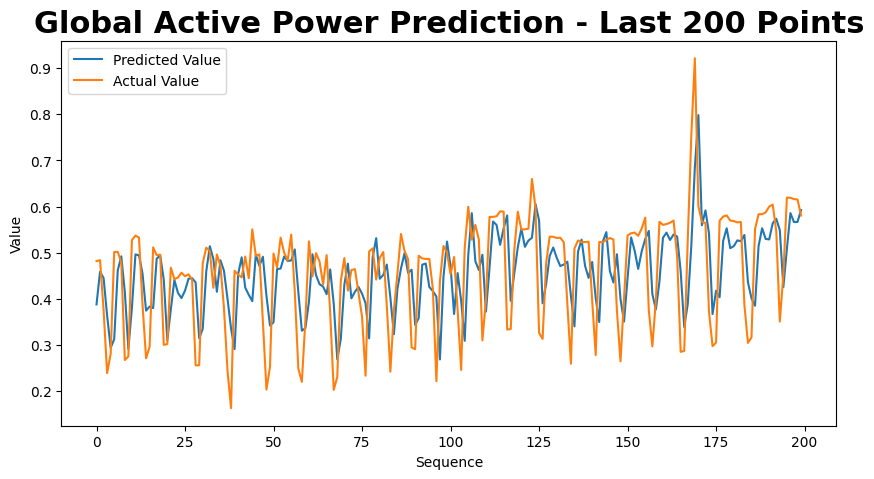

In [56]:
# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_val[-200:], label='Predicted Value')
plt.plot(y_true_val[-200:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 200 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Sequence')
plt.legend()
plt.show()

# Optionally, save the plot to a file
fig_verify.savefig("model_validation_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:


The adjustments made to the LSTM model, including the incorporation of Conv1D layers and dropout regularization, effectively enhanced its performance on the validation data, evidenced by a gradual decrease in Mean Squared Error (MSE) to 0.0058. These improvements likely stem from the model's increased capacity to capture both temporal sequences and spatial dependencies in the data, crucial for accurately forecasting time series like Global Active Power (GAP). To optimize further for production, especially in an IoT context where efficiency is key, one could explore reducing model complexity, implementing model compression techniques, or leveraging hardware acceleration to balance accuracy with computational demands.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:

In comparing the models built in this assignment to the linear regression model from last week, the contrast in performance is quite stark. The LSTM models we explored this week demonstrated a significant leap in predictive accuracy, with MSE scores plummeting to 0.0058, far surpassing last week's linear regression model that scored an MSE of 0.511. This leap underscores the advanced capability of LSTM models to capture and learn from the sequential patterns inherent in time-series data like household electricity usage. However, this improved performance comes with increased computational demands, a critical consideration for IoT devices. Linear regression, with its simplicity and lower resource requirements, provides a straightforward yet effective approach, making it an attractive option for less capable devices.

Choosing the right model for an IoT system tasked with predicting the Global Active Power (GAP) for a household hinges on striking a balance between accuracy and operational feasibility. For high-end IoT devices equipped with ample computational resources, an LSTM model would be my go-to choice due to its superior accuracy and ability to model complex temporal relationships. This choice would ensure the most reliable predictions for managing electricity consumption efficiently. Conversely, for more basic IoT setups with stringent resource limitations, I would lean towards the linear regression model. Its lower computational footprint makes it a practical choice, offering a commendable level of accuracy that suffices for short-term predictive horizons like 5 minutes, ensuring the system remains responsive without overtaxing the device's capabilities.